In [1]:
#!pip uninstall torch torchvision torchdata torchtext -y
#!pip install torch==1.13.0 torchvision==0.14.0 torchaudio==0.13.0

#import torch
#import torchvision

#print("pytorch version: ", torch.__version__)
#print("torchvision version: ", torchvision.__version__)
#!python --version

import importlib.util
coremltools_check = importlib.util.find_spec("coremltools")
have_coremltools = coremltools_check is not None
if not have_coremltools:
  !pip install coremltools
  !python3 convert-script.py

import coremltools as ct

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 5.8 MB/s eta 0:00:00
python3: can't open file '/content/convert-script.py': [Errno 2] No such file or directory


In [2]:
!ln -s /content/drive/MyDrive/Colab\ Notebooks/Mobile-Unet/utils ./
!ln -s /content/drive/MyDrive/OkraInsight/training_data ./
!ln -s /content/drive/MyDrive/OkraInsight/.ipynb_checkpoints ./

import argparse
import logging
import os
import random
import sys
import glob
import cv2
import pickle
import torch

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt


from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split


from utils.data_loading import BasicDataset, OkraDataset

In [3]:
# 1. Create dataset
import torchvision

dir_img = Path('./training_data/okra_images/class_okra_surface')
dir_mask = Path('./training_data/okra_segmentation_target_masks')
dir_checkpoint = Path('./checkpoint')
img_scale = 0.1

normalize = torchvision.transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
dataset = OkraDataset(dir_img, dir_mask, normalize, img_scale)





100%|██████████| 31/31 [00:12<00:00,  2.56it/s]


In [ ]:
# 2. Split into train / validation partitions
# val_percent = 0.1
# n_val = int(len(dataset) * val_percent)
# n_train = len(dataset) - n_val
# print("n_val = ", n_val, ", n_train = ", n_train)
# train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

In [4]:
# 3. Create data loaders
batch_size = 1
loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
test_loader = DataLoader(dataset, shuffle=False, drop_last=True, **loader_args)

# batch_size = 2 ==> torch.Size([2, 3, 3024, 4032]) x18
# batch_size = 3 ==> torch.Size([3, 3, 3024, 4032]) x12
#
# for batch in train_loader:
#  images, true_masks = batch['image'], batch['mask']
#  print(images.shape)

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        #color = np.array([30/255, 144/255, 255/255, 0.6])
        color = np.array([0/255, 0/255, 0/255, 1])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_image_with_mask(image, mask, iter_cnt, img_name):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    plt.title(f"Mask for image # {iter_cnt} {img_name}", fontsize=18)
    # plt.axis('off')
    plt.show()

In [6]:
# model = torch.load('.ipynb_checkpoints/deeplabv3_scripted.pt')
# model = torch.load('.ipynb_checkpoints/okra_u2net_epochs_100.pt')
model = torch.load('.ipynb_checkpoints/okra_u2net_orig.pt')
# model.to(torch.device("cpu"))
# use deeplabv3_resnet50 instead of deeplabv3_resnet101 to reduce the model size
# model = torch.hub.load('pytorch/vision:v0.8.0', 'deeplabv3_resnet50', pretrained=True)
model = model.eval()

/usr/local/lib/python3.10/dist-packages/torch/serialization.py:995: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [ ]:
piter = iter(model.parameters())
piter_cnt = 0

In [6]:
try:
  paramset = next(piter)
  piter_cnt += 1
  # print("paramset ", paramset.data)
except StopIteration:
  print("Reached end of iteration. last count is ", piter_cnt)
except Exception as e: print(e)


name 'piter' is not defined


In [49]:
# preprocess = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

it = iter(test_loader)
iter_cnt = 0

In [55]:
try:
  sample_batch = next(it)
  iter_cnt += 1
  print("image # ", iter_cnt)
except StopIteration:
  print("Reached end of iteration. last count is ", iter_cnt)
except Exception as e: print(e)

image #  2


In [57]:
image, label = sample_batch['image'], sample_batch['mask']

label = label.reshape(image.shape[0], -1, image.shape[2], image.shape[3])

good_okra_label = label[0][0]
bad_okra_label = label[0][1]


# reduce to 3D for PIL display:  torch.Size([1, 3, 302, 403]) --> torch.Size([3, 302, 403])
img_tensor = image.squeeze(0)

image shape before squeeze  torch.Size([1, 3, 302, 403])
image shape after squeeze  torch.Size([3, 302, 403])


image shape after permute  (302, 403, 3)
images.shape =  <class 'torch.Tensor'> torch.float32 torch.Size([3, 302, 403])
true_masks.shape =  <class 'torch.Tensor'> torch.bool torch.Size([1, 2, 302, 403])


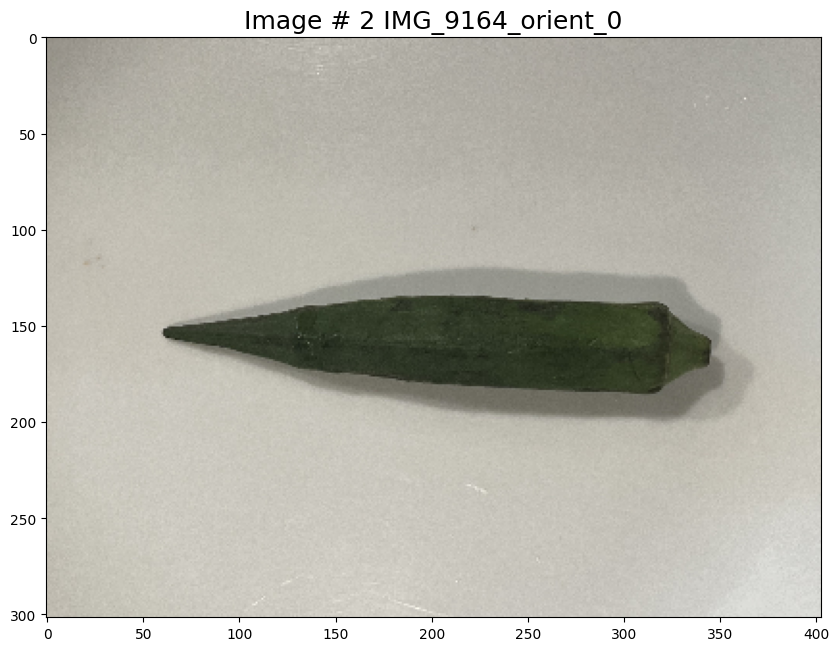

In [58]:
img_nparray = img_tensor.permute(1, 2, 0).numpy()
print("image shape after permute ", img_nparray.shape)

print("images.shape = ", type(img_tensor) , img_tensor.dtype , img_tensor.shape)
print("true_masks.shape = ", type(label), label.dtype, label.shape)

plt.figure(figsize=(10,10))
img_name = dataset.ids[iter_cnt - 1]
plt.title(f"Image # {iter_cnt} {img_name}", fontsize=18)
plt.imshow(img_nparray)

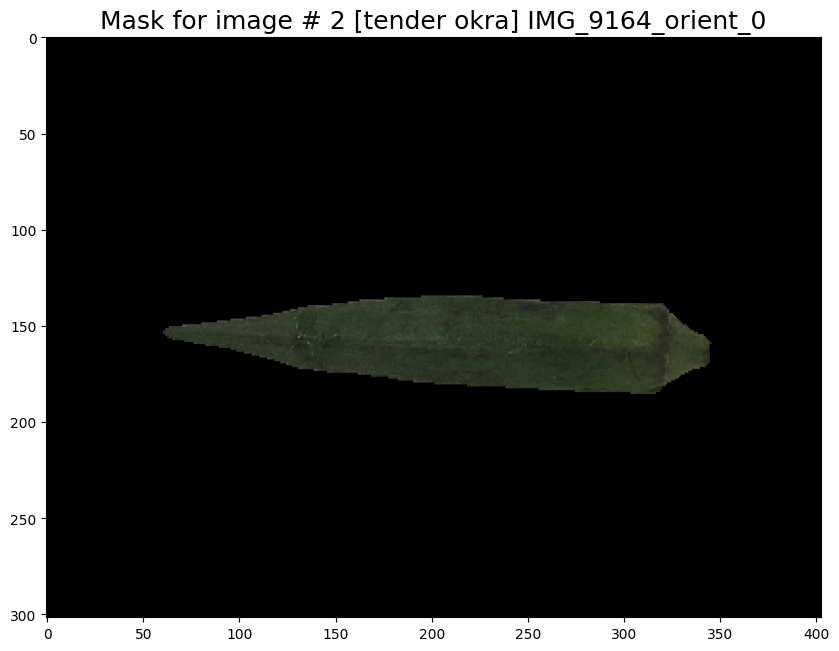

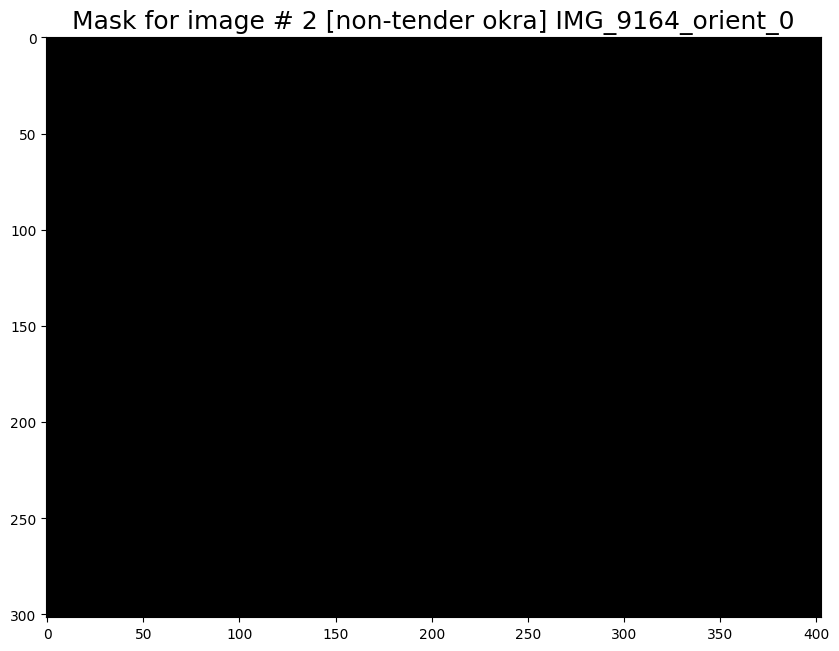

In [62]:
# inverse mask preserves Okra and blackens out background
inv_goodokra_label = ~good_okra_label
inv_badokra_label = ~bad_okra_label
show_image_with_mask(img_nparray, inv_goodokra_label, iter_cnt, "[tender okra] " + img_name)
show_image_with_mask(img_nparray, inv_badokra_label, iter_cnt, "[non-tender okra] " + img_name)

In [72]:
# print(type(image), image.dtype, image.shape)
# get 1 raster line of input at height=200 for charting model input vs response
#print(image[0,0,:,200])

tensor(2)


In [ ]:
# model.eval()

# mask_pred = model(image)['out'].detach()
d0, d1, d2, d3, d4, d5, d6 = model(image)
mask_pred =  d0.squeeze(1)
#print(mask_pred.shape)
#print(mask_pred.dtype)
#print(mask_pred[0,:,200])

In [65]:
# print(mask_pred.shape)
# print(mask_pred[mask_pred > 0.95].mean())

torch.Size([1, 302, 403])
min =  tensor(6.7002e-10)
max =  tensor(1.0000)
max =  tensor(0.1260)
tensor(0.9965, grad_fn=<MeanBackward0>)


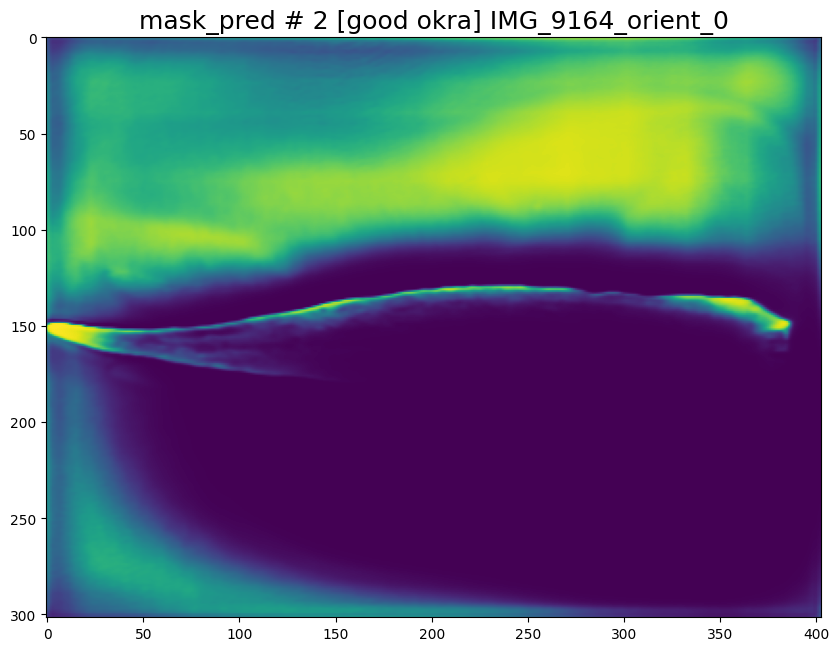

In [64]:
#print(mask_pred[0,0,:,200])

# print(image.shape)


good_okra = mask_pred.detach()[0][0]
good_okra_tensor = good_okra.squeeze(0)
good_okra_nparray = good_okra_tensor.numpy()


plt.figure(figsize=(10,10))
img_name = dataset.ids[iter_cnt - 1]
plt.title(f"mask_pred # {iter_cnt} [good okra] {img_name}", fontsize=18)
plt.imshow(good_okra_nparray)

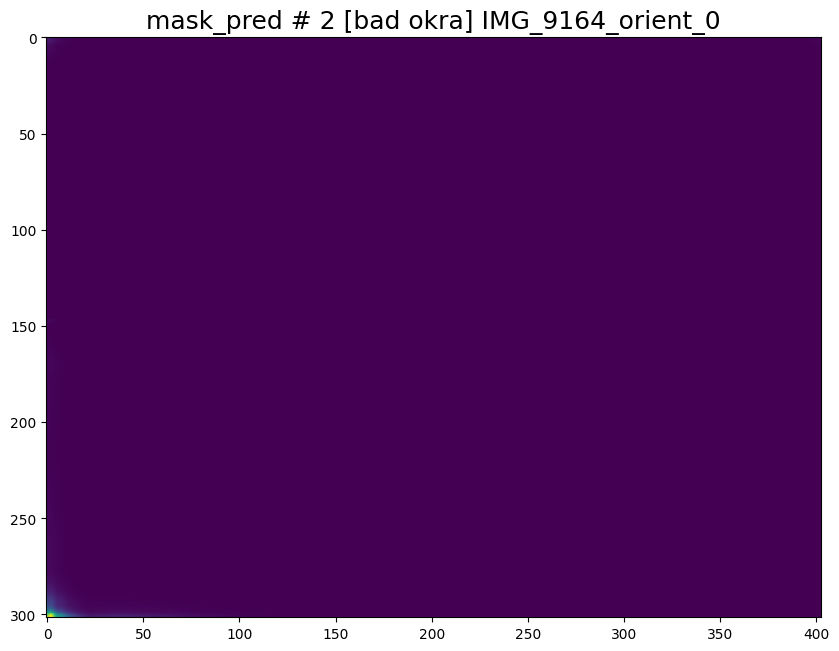

In [65]:
bad_okra = mask_pred.detach()[0][1]
bad_okra_tensor = bad_okra.squeeze(0)
bad_okra_nparray = bad_okra_tensor.numpy()

plt.figure(figsize=(10,10))
img_name = dataset.ids[iter_cnt - 1]
plt.title(f"mask_pred # {iter_cnt} [bad okra] {img_name}", fontsize=18)
plt.imshow(bad_okra_nparray)

# this doesnt work with mobilenet

#traceable_model = model.eval()
#trace = torch.jit.trace(traceable_model, image)

#mlmodel = ct.convert(
#    trace,
#    inputs=[ct.TensorType(name="input", shape=image.shape)],
#)

In [70]:
good_okra = (good_okra >= 0.5)
bad_okra = (bad_okra >= 0.5)

# im2 = image * good_okra

# img2_tensor = im2.squeeze(0)
# img2_nparray = img2_tensor.permute(1, 2, 0).numpy()
# plt.figure(figsize=(10,10))
# img_name = dataset.ids[iter_cnt - 1]
# plt.title(f"mask_pred with image # {iter_cnt} {img_name}", fontsize=18)
# plt.imshow(img2_nparray)

torch.bool


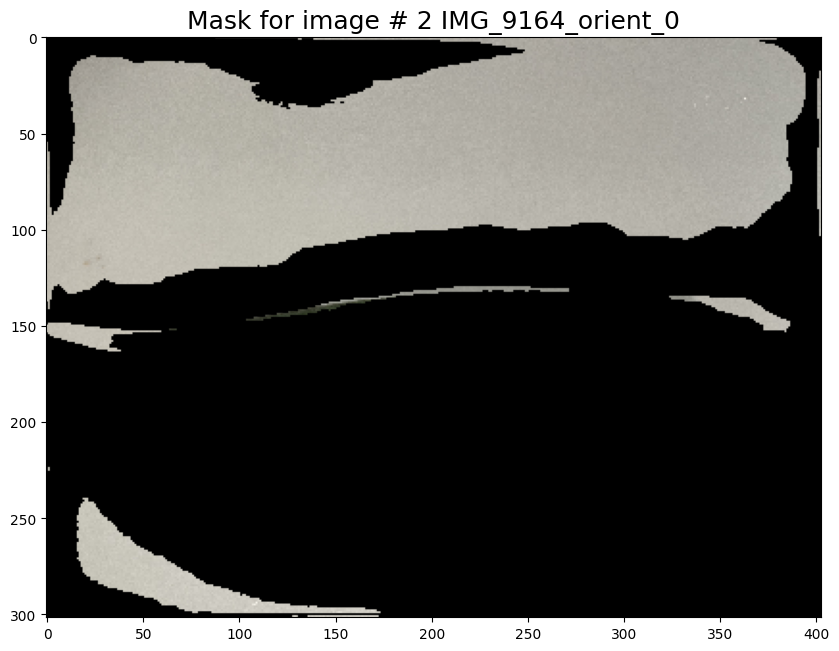

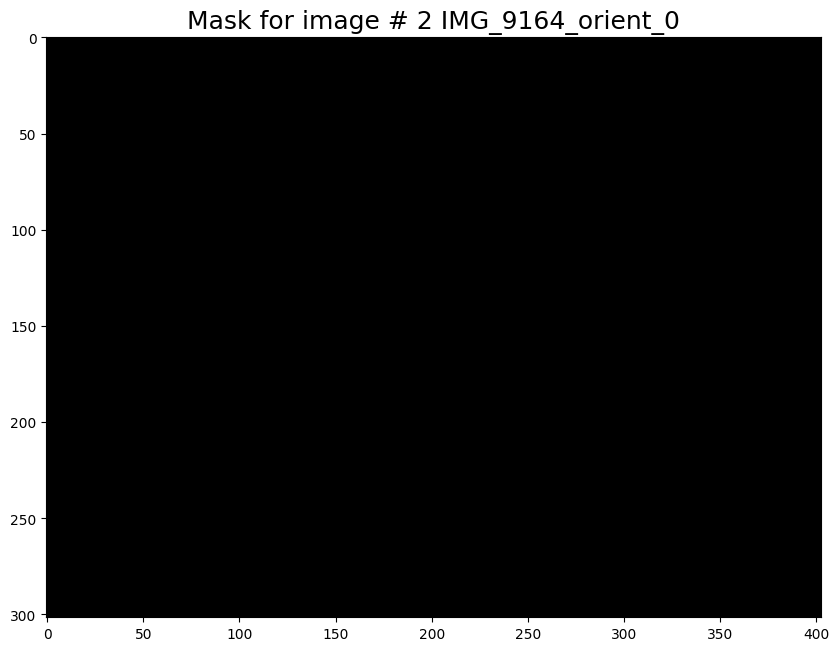

In [71]:
show_image_with_mask(img_nparray, ~good_okra, iter_cnt, img_name)
show_image_with_mask(img_nparray, ~bad_okra, iter_cnt, img_name)